# Import

In [3]:
import os
import warnings
import cv2
import keras
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
from PIL import Image
from keras import models, layers, optimizers
from keras.applications import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import datetime
import pickle
from matplotlib import pyplot as plt
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
from sklearn.metrics import multilabel_confusion_matrix
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

Done@2020-12-30T21Z


# Use Colab ?

In [4]:
USE_COLAB = False # change to 0 if not use colab

In [ ]:
if USE_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# cd den thu muc chua proj
if USE_COLAB:
    %cd /content/drive/'My Drive'/_MachineLearningProj
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

/content/drive/My Drive/_MachineLearningProj
Done@2020-12-29T15Z


# Declare variable and function

In [3]:
# Dinh nghia cac bien

gestures = {'L_': 'L',
           'fi': 'E',
           'ok': 'F',
           'pe': 'V',
           'pa': 'B'
            }

gestures_map = {'E': 0,
                'L': 1,
                
                'F': 2,
                'V': 3,
                'B': 4
                }


gesture_names = {0: 'E',
                 1: 'L',
                 2: 'F',
                 3: 'V',
                 4: 'B'}


if (USE_COLAB):
    image_path = '/content/drive/MyDrive/_MachineLearningProj/MiAI_Hand_Lang/data'
    models_path = '/content/drive/MyDrive/_MachineLearningProj/MiAI_Hand_Lang/models/saved_model.hdf5'
else:
    image_path = 'D:/Documents/_HOC_DAI_HOC/NAM_4/HocKi1/MachineLearning/MiAI_Hand_Lang/data'
    models_path = 'D:/Documents/_HOC_DAI_HOC/NAM_4/HocKi1/MachineLearning/MiAI_Hand_Lang/models/saved_model.hdf5'
rgb = False
imageSize = 224


# Ham xu ly anh resize ve 224x224 va chuyen ve numpy array
def process_image(path):
    img = Image.open(path)
    img = img.resize((imageSize, imageSize))
    img = np.array(img)
    return img

# Xu ly du lieu dau vao
def process_data(X_data, y_data):
    X_data = np.array(X_data, dtype = 'float32')
    if rgb:
        pass
    else:
        X_data = np.stack((X_data,)*3, axis=-1)
    X_data /= 255
    y_data = np.array(y_data)
    y_data = to_categorical(y_data)
    return X_data, y_data

# Ham duyet thu muc anh dung de train
def walk_file_tree(image_path):
    X_data = []
    y_data = []
    for directory, subdirectories, files in os.walk(image_path):
        for file in files:
            if not file.startswith('.'):
                path = os.path.join(directory, file)
                gesture_name = gestures[file[0:2]]
                # print(gesture_name)
                # print(gestures_map[gesture_name])
                y_data.append(gestures_map[gesture_name])
                X_data.append(process_image(path))

            else:
                continue

    X_data, y_data = process_data(X_data, y_data)
    return X_data, y_data
import datetime
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

Done@2020-12-30T20Z


In [4]:
# Load du lieu vao X va Y
X_data, y_data = walk_file_tree(image_path)
print("X_data.shape = ", X_data.shape)
import datetime
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

X_data.shape =  (2748, 224, 224, 3)
Done@2020-12-30T20Z


# Initialize model

In [ ]:
# Dat cac checkpoint de luu lai model tot nhat
model_checkpoint = ModelCheckpoint(filepath=models_path, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_acc',
                               min_delta=0,
                               patience=10,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True)

In [ ]:
# Khoi tao model
model1 = VGG16(weights='imagenet', include_top=False, input_shape=(imageSize, imageSize, 3))
optimizer1 = optimizers.Adam()
base_model = model1

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
# Them cac lop ben tren
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
x = Dense(128, activation='relu', name='fc2a')(x)
x = Dense(128, activation='relu', name='fc3')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', name='fc4')(x)

In [ ]:
# Them lop cuoi
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Dong bang cac lop duoi, chi train lop ben tren minh them vao
for layer in base_model.layers:
    layer.trainable = False

# Split whold data to Train, Validation, Test Set

<pre>
*   Train Set:      64%
*   Validation Set: 16%
*   Test Set:       20%
</pre>


In [5]:
# Phan chia du lieu train, val, test theo ti le 64:16:20
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state=12, stratify=y_data)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=12, stratify=y_train)

# Train Final Model

In [ ]:
# Final model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_val, y_val), verbose=1,
          callbacks=[early_stopping, model_checkpoint])
# save history to file
if (USE_COLAB):
    f = open('/content/drive/MyDrive/_MachineLearningProj/MiAI_Hand_Lang/history_final.pckl', 'wb')
else:
    f = open('D:/Documents/_HOC_DAI_HOC/NAM_4/HocKi1/MachineLearning/___CuoiKi/Code/MiAI_Hand_Lang/history/history_final.pckl', 'wb')
pickle.dump(hist.history, f)
f.close()
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

# Draw train loss, val loss

## Final Model's

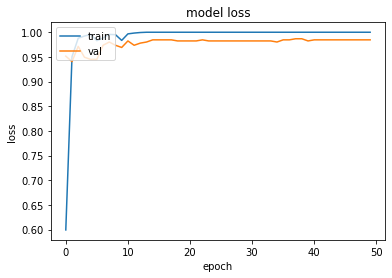

Done@2020-12-30T21Z


In [11]:
  if (USE_COLAB):
    f = open('/content/drive/MyDrive/_MachineLearningProj/MiAI_Hand_Lang/histories/history_final.pckl', 'rb')
  else:
    f = open('D:/Documents/_HOC_DAI_HOC/NAM_4/HocKi1/MachineLearning/___CuoiKi/Code/MiAI_Hand_Lang/history/history_final.pckl', 'rb')
  history = pickle.load(f)
  f.close()
  # plot
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'val'], loc='upper left')
  # plt.savefig('D:/Documents/_HOC_DAI_HOC/NAM_4/HocKi1/MachineLearning/___CuoiKi/Code/MiAI_Hand_Lang/result_image_plot/model_loss.png')
  plt.show()
  print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

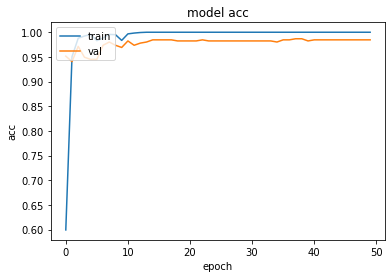

Done@2020-12-30T22Z


In [13]:
 # plot
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('D:/Documents/_HOC_DAI_HOC/NAM_4/HocKi1/MachineLearning/___CuoiKi/Code/MiAI_Hand_Lang/result_image_plot/model_loss.png')
plt.show()
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

## Save final model

In [20]:
# Luu model da train ra file
import datetime
if (USE_COLAB):
    model.save('/content/drive/MyDrive/_MachineLearningProj/MiAI_Hand_Lang/models/mymodel_final.h5')
else:
    model.save('D:/Documents/_HOC_DAI_HOC/NAM_4/HocKi1/MachineLearning/MiAI_Hand_Lang/models/mymodel_final.h5')
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

NameError: name 'model' is not defined

# Download file

In [ ]:
# download file tu colab ve
if (USE_COLAB):
    from google.colab import files
    files.download('/content/drive/MyDrive/_MachineLearningProj/MiAI_Hand_Lang/models/mymodel_final.h5')
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

In [ ]:
if (USE_COLAB):
    from google.colab import files 
    files.download('/content/drive/MyDrive/_MachineLearningProj/MiAI_Hand_Lang/histories/history_final.pckl')
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

# Confusion Matrix

In [26]:
if (USE_COLAB):
    model_trained = load_model('/content/drive/MyDrive/_MachineLearningProj/MiAI_Hand_Lang/models/mymodel_final.h5')
else:
    # model_trained = load_model("D:/Documents/_HOC_DAI_HOC/NAM_4/HocKi1/MachineLearning/___CuoiKi/Code/MiAI_Hand_Lang/models/mymodel_final.h5")
    model_trained = load_model("D:/Documents/_HOC_DAI_HOC/NAM_4/HocKi1/MachineLearning/___CuoiKi/Code/MiAI_Hand_Lang/models/mymodel_final.h5")
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

Done@2020-12-30T13Z


In [27]:
y_pred = model_trained.predict(X_test)
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

Done@2020-12-30T13Z


## Label y_pred and y_test

In [28]:
# labled y_pred
print(y_pred.shape)
y_pred_labelled = []
for i in range(0, 550):
    y_pred_labelled.append(gesture_names[np.argmax(y_pred[i])])
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

(550, 5)
Done@2020-12-30T13Z


In [29]:
# labled y_test
print(y_test.shape)
y_test_labelled = []
for i in range(0, 550):
    y_test_labelled.append(gesture_names[np.argmax(y_test[i])])
import datetime
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

(550, 5)
Done@2020-12-30T13Z


### Confusion Matrix for Multiple Classes


Act Label\Pred Label| E | L | F | V | B
---:|:---:|:---:|:---:| ---
**E** | Pee | Pel | Pef | Pev | Pev
**L** | Ple | Pll | Plf | Plv | Plv
**F** | Pfe | Pfl | Pff | Pfv | Pfv
**V** | Pve | Pvl | Pvf | Pvv | Pvv
**B** | Pbe | Pbl | Pbf | Pbv | Pbv

In [30]:
conf_mat = confusion_matrix(y_test_labelled, y_pred_labelled, labels=["E", "L", "F", "V", "B"])
table = tabulate(conf_mat, headers=["E", "L", "F", "V", "B"], tablefmt='fancy_grid')
print("Confusion Matrix")
print(table)
import datetime
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

Confusion Matrix
╒═════╤═════╤═════╤═════╤═════╕
│   E │   L │   F │   V │   B │
╞═════╪═════╪═════╪═════╪═════╡
│ 110 │   0 │   0 │   0 │   0 │
├─────┼─────┼─────┼─────┼─────┤
│   0 │ 110 │   0 │   0 │   0 │
├─────┼─────┼─────┼─────┼─────┤
│   0 │   0 │ 110 │   0 │   0 │
├─────┼─────┼─────┼─────┼─────┤
│   0 │   0 │   0 │ 110 │   0 │
├─────┼─────┼─────┼─────┼─────┤
│   0 │   0 │   0 │   0 │ 110 │
╘═════╧═════╧═════╧═════╧═════╛
Done@2020-12-30T13Z


### Confusion Matrix for each Label
Actual\Predict| Pred Neg | Pred Pos
---:|:---:| ---
**Act Neg** | TN | FP
**Act Pos** | FN | TP

In [31]:
mul_conf_mat = multilabel_confusion_matrix(y_test_labelled, y_pred_labelled, labels=["E", "L", "F", "V", "B"])
table = tabulate(mul_conf_mat[0], tablefmt='fancy_grid')
print("E")
print(table)
table = tabulate(mul_conf_mat[1], tablefmt='fancy_grid')
print("L")
print(table)
table = tabulate(mul_conf_mat[2], tablefmt='fancy_grid')
print("F")
print(table)
table = tabulate(mul_conf_mat[3], tablefmt='fancy_grid')
print("V")
print(table)
table = tabulate(mul_conf_mat[4], tablefmt='fancy_grid')
print("B")
print(table)
import datetime
print("Done@" + datetime.datetime.now().strftime("%Y-%m-%dT%HZ"))

E
╒═════╤═════╕
│ 440 │   0 │
├─────┼─────┤
│   0 │ 110 │
╘═════╧═════╛
L
╒═════╤═════╕
│ 440 │   0 │
├─────┼─────┤
│   0 │ 110 │
╘═════╧═════╛
F
╒═════╤═════╕
│ 440 │   0 │
├─────┼─────┤
│   0 │ 110 │
╘═════╧═════╛
V
╒═════╤═════╕
│ 440 │   0 │
├─────┼─────┤
│   0 │ 110 │
╘═════╧═════╛
B
╒═════╤═════╕
│ 440 │   0 │
├─────┼─────┤
│   0 │ 110 │
╘═════╧═════╛
Done@2020-12-30T13Z


In [32]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_labelled, y_pred_labelled)

1.0

## Measure Accuracy base Confusion matrix

In [33]:
np.sum(conf_mat)
accur = (conf_mat[0,0] + conf_mat[1,1] + conf_mat[2,2] + conf_mat[3,3] + conf_mat[4,4]) / np.sum(conf_mat)
print(accur)

1.0
